# Augmentation Overview

All the transformtions and their parameter were chosen only based on visual analysis of produced result, there was not exploratory analysis of colors distibutution performed or any other advanced image specific preparing steps.

In [1]:
import torch
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from PIL import Image
from IPython.display import clear_output
from tqdm.auto import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.facecolor'] = 'seashell'
import os
import glob
import time

import warnings
warnings.simplefilter("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gpu = None
if device != torch.device('cpu'):
    gpu = !nvidia-smi --query-gpu=gpu_name  --format=csv,noheader
print(f'Device: {device}\n'
      f'GPU: {gpu}\n'
      f'PyTorch version: {torch.__version__}')

Device: cuda:0
GPU: ['Tesla K80']
PyTorch version: 1.9.0+cu102


In [2]:
# Visualization

def show_tensor_images(image_tensor, num_images=25, ax=None):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_tensor = image_tensor.detach().cpu()
    if num_images > 1:
      image_tensor = make_grid(image_tensor[:num_images], nrow=int(num_images**0.5), padding=1)
    image_tensor = image_tensor.permute(1, 2, 0).squeeze()
    if ax is None:
        ax = plt
    ax.imshow(image_tensor)
    ax.axis('off')

In [3]:
# load the frog dataset
!git clone https://github.com/jonshamir/frog-dataset.git /content/data

Cloning into '/content/data'...
remote: Enumerating objects: 53349, done.
remote: Total 53349 (delta 0), reused 0 (delta 0), pack-reused 53349
Receiving objects: 100% (53349/53349), 1.02 GiB | 34.83 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Checking out files: 100% (23392/23392), done.


In [4]:
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.png')
        self.transform = transform

    def __getitem__(self, index):
        x = Image.open(self.image_paths[index])
        # remove alpha channel
        background = Image.new('RGBA', x.size, (255,255,255))
        x = Image.alpha_composite(background, x)
        x = x.convert('RGB')
        if self.transform is not None:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.image_paths)

## Augmentation

Transforming 224x224 images and then resizing, to get better result

In [5]:
def vizualize_augmentation(batch, transforms_list, transformed_to_tensor=True):
    fig, axs = plt.subplots(1, 2, figsize=(13, 6.5), tight_layout=True)

    orig_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((64, 64)),
      transforms.Normalize([0.5], [0.5]),
    ])

    if transformed_to_tensor:
        transforms_list.append(transforms.ToTensor())
    transforms_list.append(transforms.Normalize([0.5], [0.5]))
    transform = transforms.Compose(transforms_list)

    viz_batch = torch.stack([orig_transform(im) for im in batch])
    show_tensor_images(viz_batch, ax=axs[0])
    transformed = torch.stack([transform(im) for im in batch])
    show_tensor_images(transformed, ax=axs[1])
    axs[0].set_title('Original', fontsize=14)
    axs[1].set_title('Transformed', fontsize=14)

In [6]:
TRAIN_DATA_PATH = '/content/data/data-224/'
train_data = UnlabeledDataset(path=TRAIN_DATA_PATH)

batch = [train_data[i] for i in range(25)]

#### 1. Random Horizontal Flip

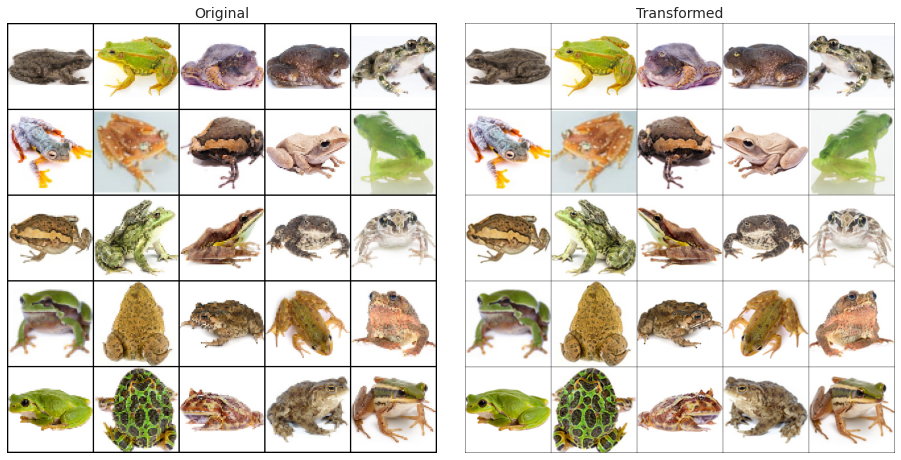

In [7]:
vizualize_augmentation(batch, [transforms.RandomHorizontalFlip()])

#### 2. Random Perspective

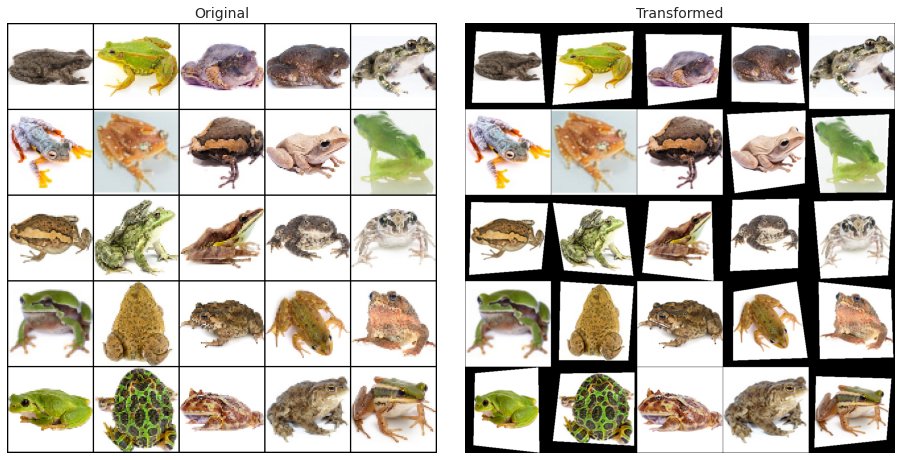

In [8]:
vizualize_augmentation(batch, [transforms.RandomPerspective(distortion_scale=0.30, p=0.5)])

#### 3. Random Rotation

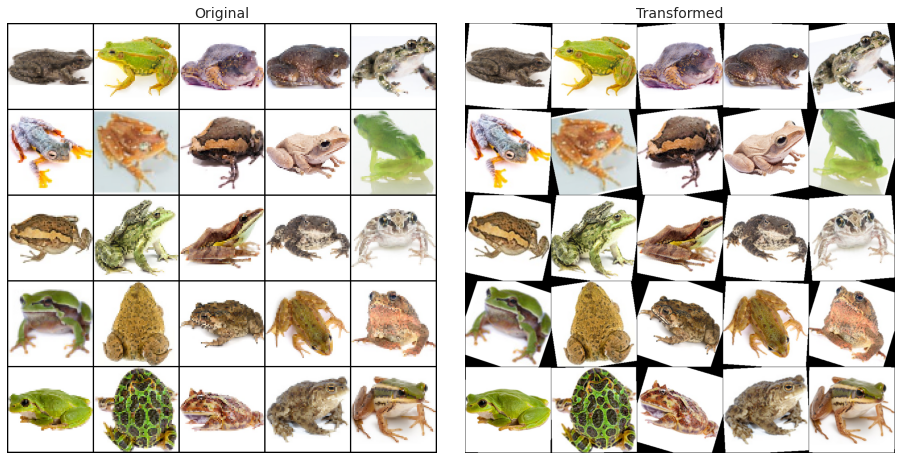

In [9]:
vizualize_augmentation(batch, [transforms.RandomRotation(20)])

#### 4. Color Jitter

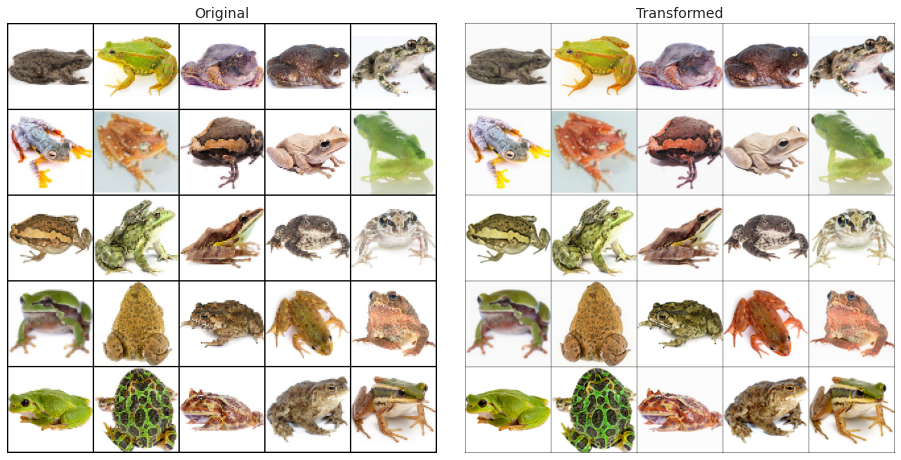

In [10]:
vizualize_augmentation(batch, [transforms.ColorJitter(brightness=0, contrast=0.1, saturation=0.3, hue=0.05)])

#### 5. Resizing + Gaussian Blur
To make images edges more smooth

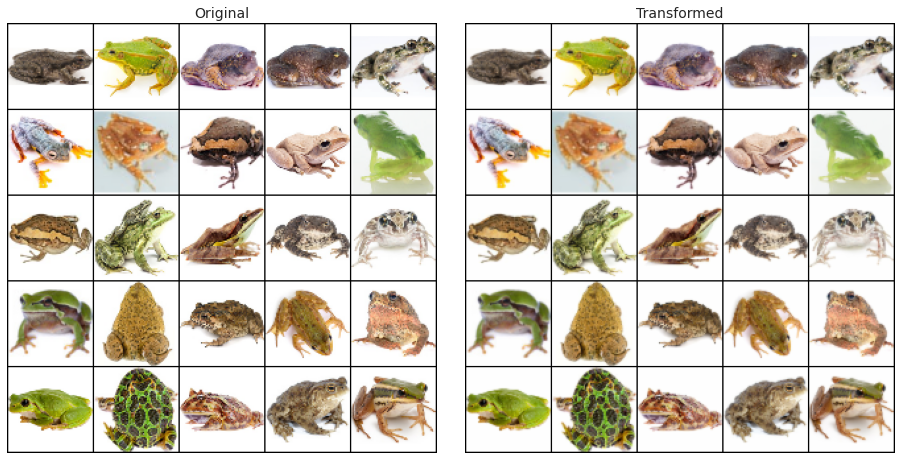

In [11]:
vizualize_augmentation(
    batch, 
    [
     transforms.ToTensor(),
     transforms.Resize((64, 64)),
     transforms.GaussianBlur(kernel_size=(3, 3), sigma=0.45)
    ],
    False
)

#### All Together

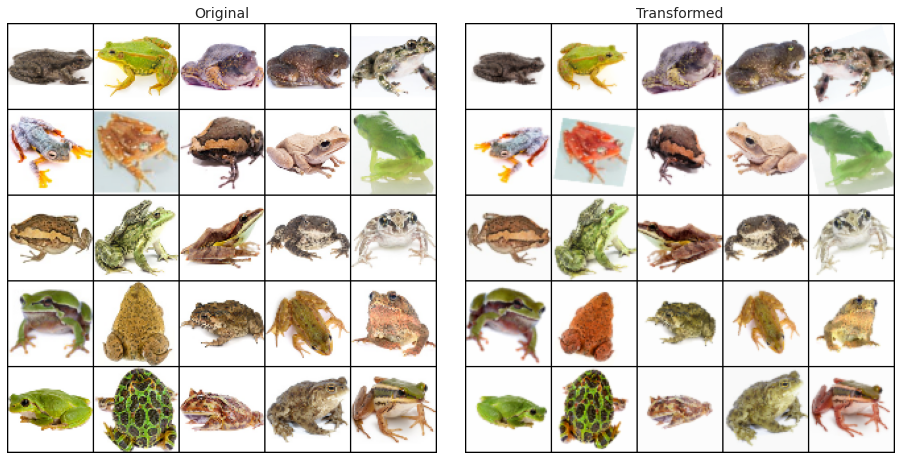

In [12]:
TRANSFORM_IMG = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(distortion_scale=0.30, p=0.5, fill=(255,255,255)),
    transforms.RandomRotation(20, fill=(255,255,255)),
    transforms.ColorJitter(brightness=0., contrast=0.1, saturation=0.3, hue=0.05),

    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=0.45)
]

vizualize_augmentation(batch, TRANSFORM_IMG, False)